In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [1]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    FormFactorFile,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan, load_energy_scans,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import fit_differential_evolution, FitContext, FitTransform, TVRegularizer

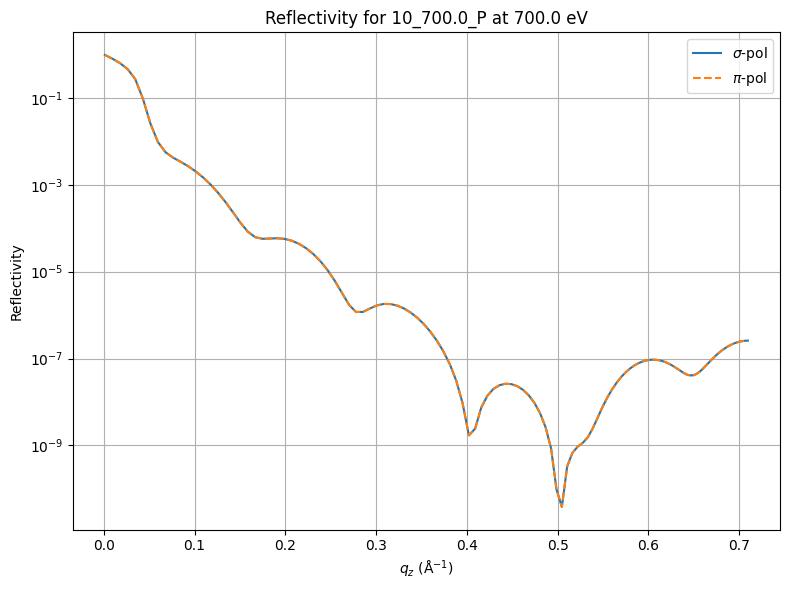

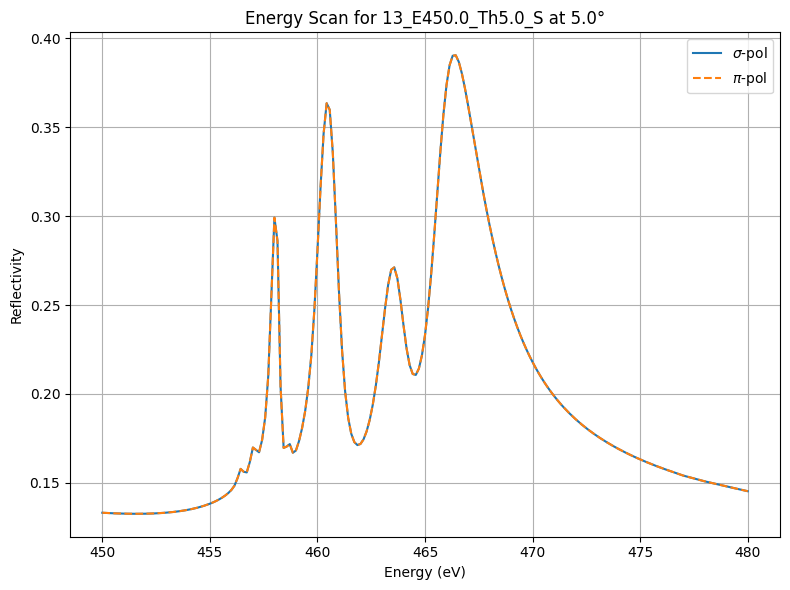

In [4]:
from rxrmask.core import ReflectivityScan, EnergyScan
import h5py

data_file = h5py.File('/Users/niaggar25/Developer/mitacs/GO-RXR/DOCS/Tutorial/example1.h5', 'r')
experiment = data_file['Experimental_data']

RS = experiment['Reflectivity_Scan']
ES = experiment['Energy_Scan']

ref_scans = []
ene_scans = []

for Rkey in RS.keys():
    data = RS[Rkey]
    qz = data[0, :]
    r = data[2, :]
    dat = ReflectivityScan(
        name=Rkey,
        energy_eV=float(data.attrs['Energy']),
        pol=data.attrs['Polarization'].lower(),
        qz=qz,
        R=r,
        bounds=[(qz[0], qz[-1])],
        weights=[1]
    )
    ref_scans.append(dat)

for Ekey in ES.keys():
    data = ES[Ekey]
    e = data[3, :]
    r = data[2, :]
    dat = EnergyScan(
        name=Ekey,
        theta_deg=float(data.attrs['Angle']),
        pol=data.attrs['Polarization'].lower(),
        E_eV=e,
        R=r,
        bounds=[(e[0], e[-1])],
        weights=[1]
    )
    ene_scans.append(dat)

test_scan = ref_scans[0]
plot_reflectivity(test_scan.qz, test_scan.R, test_scan.R, test_scan.energy_eV, test_scan.name)

test_scan_ene = ene_scans[0]
plot_energy_scan(test_scan_ene.E_eV, test_scan_ene.R, test_scan_ene.R, test_scan_ene.theta_deg, test_scan_ene.name)




In [17]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False, offset=-1.1)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False, offset=0.5)
la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)
x1_atom = Atom(
    Z=0,
    name="X1",
    ff=c_ff,
)
x2_atom = Atom(
    Z=0,
    name="X2",
    ff=c_ff,
)

In [18]:
def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")

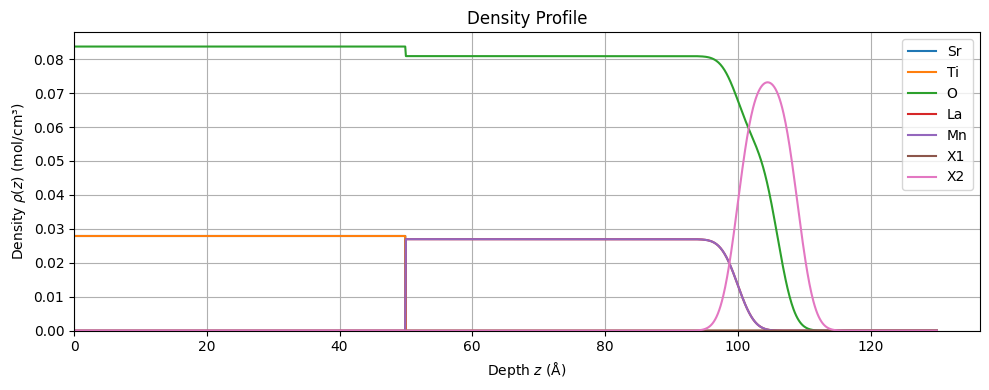

In [19]:
parameters_container = ParametersContainer()
substrate = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=0.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
layer1 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:1,Mn:1,O:3",
    thickness=50.0,
    density=6.52,
    atoms=[la_atom, mn_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)
layer2 = create_compound(
    parameters_container=parameters_container,
    name="CCO",
    formula="X1:1,X2:1,O:1",
    thickness=10.0,
    density=5,
    atoms=[x1_atom, x2_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

layer2.compound_details[0].molar_density.independent = True
layer2.compound_details[0].molar_density.set(0.0)
layer2.compound_details[1].molar_density.independent = True
layer2.compound_details[1].molar_density.set(0.075)
layer2.compound_details[2].molar_density.independent = True
layer2.compound_details[2].molar_density.set(0.055)

layer2.compound_details[0].thickness.independent = True
layer2.compound_details[0].thickness.set(15.0)
layer2.compound_details[1].thickness.independent = True
layer2.compound_details[1].thickness.set(9.0)
layer2.compound_details[2].thickness.independent = True
layer2.compound_details[2].thickness.set(6.0)

layer2.compound_details[0].roughness.independent = True
layer2.compound_details[0].roughness.set(0.0)
layer2.compound_details[1].roughness.independent = True
layer2.compound_details[1].roughness.set(4.0)
layer2.compound_details[2].roughness.independent = True
layer2.compound_details[2].roughness.set(4.0)

struc = Structure(name="SrTiO3-struc", n_compounds=3, params_container=parameters_container)
struc.add_compound(0, substrate)
struc.add_compound(1, layer1)
struc.add_compound(2, layer2)
struc.validate_compounds()
struc.create_layers(step=0.1)

plot_density_profile_atoms_layers(struc.atoms_layers)

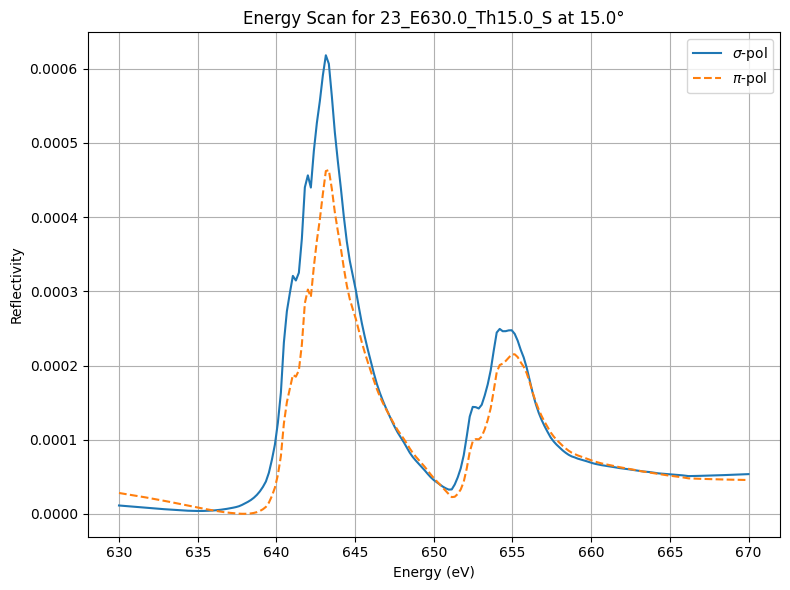

In [20]:
backend = PRReflectivityBackend(als=True)

test_scan_data = None
for e in ene_scans:
    if e.name == '23_E630.0_Th15.0_S':
        test_scan_data = e

test_en_scan = backend.compute_energy_scan(struc, test_scan_data.E_eV, test_scan_data.theta_deg)
plot_energy_scan(test_scan_data.E_eV, test_scan_data.R, test_en_scan.R_s, test_scan_data.theta_deg, test_scan_data.name)

2
Total cost: 158675.093736
Total cost: 3015835.829706
Total cost: 858089433.433028
Total cost: 6575444.851465
Total cost: 830429.091893
Total cost: 85676606.022447
Total cost: 7992977.174954
Total cost: 8949946.399169
Total cost: 8935948.437431
Total cost: 1010781.641499
Total cost: 17656842.828423
Total cost: 5819461.459132
Total cost: 138150.231714
Total cost: 13720812.651215
Total cost: 7072735.792535
Total cost: 3991326.738479
Total cost: 6064618.778730
Total cost: 60859987.027812
Total cost: 1423479.909578
Total cost: 9215378.676046
Total cost: 4892413.729303
Total cost: 7516176.919811
Total cost: 16578502.472445
Total cost: 386013.582120
Total cost: 6320165.701989
Total cost: 33262671.024184
Total cost: 2681200.250153
Total cost: 10765426.010663
Total cost: 6439756.842111
Total cost: 7385829.343748
Total cost: 29769668.556528
Total cost: 535284.484827
Total cost: 2560268.681208
Total cost: 13302653.320251
Total cost: 6540759.247404
Total cost: 372527957.130106
Total cost: 425723

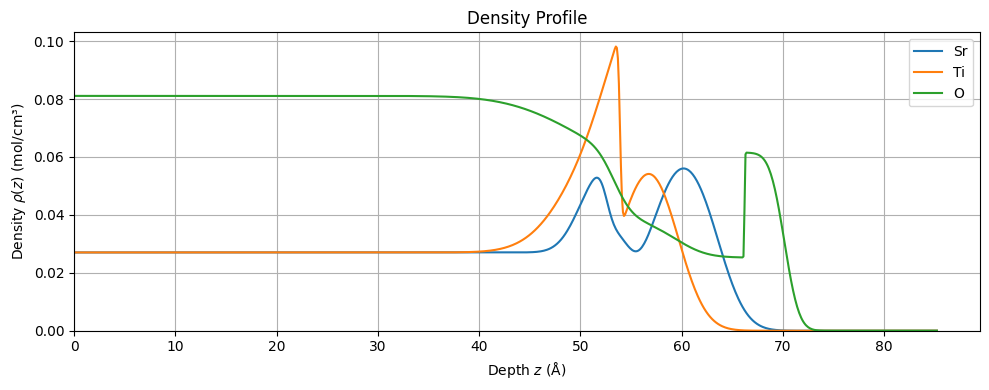

In [9]:
backend = PRParallelReflectivityBackend(als=True)
scale_param = parameters_container.new_parameter("scale", value=1.0, fit=True)
scale_param.upper = 1.0
scale_param.lower = 0.0
offset_param = parameters_container.new_parameter("offset", value=0.0, fit=True)
offset_param.upper = 2.0
offset_param.lower = 0

context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln", sim_scale=scale_param, sim_offset=offset_param),
    tv=TVRegularizer(),
    objective="chi2",
)
parameters = [
    param for param in parameters_container.parameters if param.fit
]

print(len(experimental_escans[0:2]))

res = fit_differential_evolution(
    x0=np.array(parameters_container.get_fit_vector()),
    params=parameters,
    ctx=context,
    ref_scans=[],
    # ref_scans=experimental_rscans,
    # en_scans=[],
    en_scans=experimental_escans[0:2],
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)